In [1]:
import os, sys, random
import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
class config:
    IMAGE_SIZE = 224
    BATCH_SIZE = 64
    CV = 5
    LABELS = ['REAL', 'FAKE']
    LR = 0.01
    WD = 0.
    PATIENCE = 5
    FACTOR = 0.7
    CROPS_DIR = "../input/deepfake98493faces/outputs/"

# Data

In [5]:
df = pd.read_csv("../input/deepfake98493faces/outputs/metadata.csv")
df.head()

,name_path,label
0,dfdc_train_part_43/vhphtddasg.jpg,FAKE
1,dfdc_train_part_43/egwapsifcv.jpg,FAKE
2,dfdc_train_part_43/flnyajzhsn.jpg,FAKE
3,dfdc_train_part_43/qhtynlhtjf.jpg,FAKE
4,dfdc_train_part_43/hqebuosggp.jpg,FAKE


In [7]:
len(df)

98493

How many faces of each class do we have?

Look at a random face image:

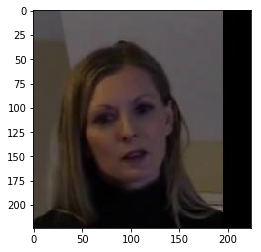

In [9]:
img_path = os.path.join(config.CROPS_DIR, np.random.choice(df.name_path.values))
plt.imshow(cv2.imread(img_path)[..., ::-1])

# Undersampling

In [10]:
df.label.value_counts()

FAKE    82419
REAL    16074
Name: label, dtype: int64

In [11]:
real_df = df[df.label == 'REAL']
fake_df = df[df.label == 'FAKE']
print('Number of real is {}'.format(len(df[df.label == "REAL"])), 'Number of fake is {}'.format(len(df[df.label == "FAKE"])))

Number of real is 16074 Number of fake is 82419


shuffle

In [13]:
from sklearn.utils import shuffle
real_df = shuffle(real_df)
fake_df = shuffle(fake_df)

divide fake_df

In [14]:
fake_sample_1 = fake_df.sample(len(real_df))
fake_left_1 = fake_df[fake_df.isin(fake_sample_1) == False].dropna()

print(len(fake_sample_1))
print(len(fake_left_1))

assert len(fake_sample_1) + len(fake_left_1) == len(fake_df)

16074
66345


In [15]:
fake_sample_2 = fake_left_1.sample(len(real_df))
fake_left_2 = fake_left_1[fake_left_1.isin(fake_sample_2) == False].dropna()

print(len(fake_sample_2))
print(len(fake_left_2))

assert len(fake_sample_2) + len(fake_left_2) == len(fake_left_1)

16074
50271


In [16]:
fake_sample_3 = fake_left_2.sample(len(real_df))
fake_left_3 = fake_left_2[fake_left_2.isin(fake_sample_3) == False].dropna()

print(len(fake_sample_3))
print(len(fake_left_3))

assert len(fake_sample_3) + len(fake_left_3) == len(fake_left_2)

16074
34197


In [17]:
fake_sample_4 = fake_left_3.sample(len(real_df))
fake_left_4 = fake_left_3[fake_left_3.isin(fake_sample_4) == False].dropna()

print(len(fake_sample_4))
print(len(fake_left_4))

assert len(fake_sample_4) + len(fake_left_4) == len(fake_left_3)

16074
18123


In [18]:
fake_sample_5 = fake_left_4.sample(len(real_df))
fake_left_5 = fake_left_4[fake_left_4.isin(fake_sample_5) == False].dropna()

print(len(fake_sample_5))
print(len(fake_left_5))

assert len(fake_sample_5) + len(fake_left_5) == len(fake_left_4)

16074
2049


train more fake data as complete as possible

In [19]:
train_df_1 = shuffle(pd.concat([real_df, fake_sample_1])).reset_index(drop=True)
print(len(train_df_1))

train_df_2 = shuffle(pd.concat([real_df, fake_sample_2])).reset_index(drop=True)
print(len(train_df_2))

train_df_3 = shuffle(pd.concat([real_df, fake_sample_3])).reset_index(drop=True)
print(len(train_df_3))

train_df_4 = shuffle(pd.concat([real_df, fake_sample_4])).reset_index(drop=True)
print(len(train_df_4))

train_df_5 = shuffle(pd.concat([real_df, fake_sample_5])).reset_index(drop=True)
print(len(train_df_5))

32148
32148
32148
32148
32148


# CV

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=2020)

train_dfs = []
val_dfs = []

for train_idx, val_idx in skf.split(np.zeros(len(train_df_1)), train_df_1.label):
#     print(train_df_1.loc[val_idx].label.value_counts()) # test if real and fake labels are even

    train_df = train_df_1.loc[train_idx]
    val_df = train_df_1.loc[val_idx]
    train_dfs.append(train_df)
    val_dfs.append(val_df)

# Augmentation

In [21]:
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = Normalize(mean, std)
unnormalize = Unnormalize(mean, std)

In [22]:
import albumentations
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize, RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression
train_transform = albumentations.Compose([ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize()
])
val_transform = albumentations.Compose([Normalize()])

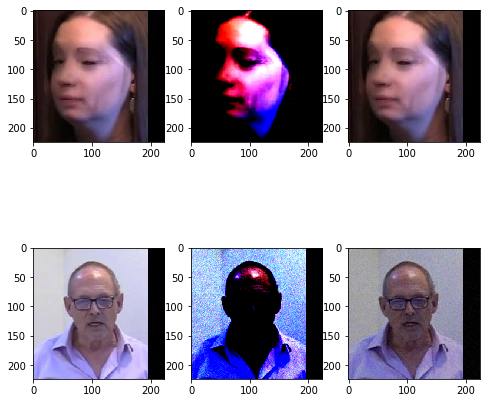

In [25]:
# effect of augmentation

img_path = os.path.join(config.CROPS_DIR, np.random.choice(df.name_path.values))
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img2 = val_transform(**{'image':img1})['image']

fig, ax = plt.subplots(2, 3, figsize=(8, 8))
ax[0, 0].imshow(img1)
ax[0, 1].imshow(img2)
ax[0, 2].imshow(unnormalize(torch.tensor(img2).permute(2, 0, 1)).permute(1, 2, 0))


img_path = os.path.join(config.CROPS_DIR, np.random.choice(df.name_path.values))
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img2 = train_transform(**{'image':img1})['image']

ax[1, 0].imshow(img1)
ax[1, 1].imshow(img2)
ax[1, 2].imshow(unnormalize(torch.tensor(img2).permute(2, 0, 1)).permute(1, 2, 0))

In [28]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):

    def __init__(self, df, split, augment=True):
        self.crops_dir = config.CROPS_DIR
        self.split = split
        self.augment = augment
        self.df = df
        
        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))
  
    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["name_path"][:-4] + ".jpg"
        cls = row["label"]
        
        # get img
        img = cv2.imread(os.path.join(self.crops_dir, row["name_path"]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # augmentation
        if self.split == 'train' and self.augment:
            img = train_transform(**{'image': img})['image']
        elif self.split == 'val' and self.augment:
            img = val_transform(**{'image': img})['image']
        img = torch.tensor(img).permute((2, 0, 1)).float()
        
        # get label
        target = config.LABELS.index(row['label'])
        
        return img, target
    
    
    
    def __len__(self):
        return len(self.df)

Let's test that the dataset actually works...

val dataset has 3215 real videos, 3215 fake videos


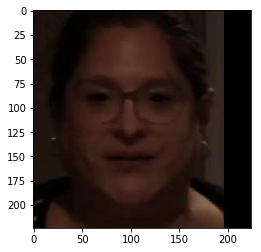

In [29]:
dataset = VideoDataset(val_dfs[0], "val")
plt.imshow(unnormalize(dataset[0][0]).permute(1, 2, 0))
del dataset

In [31]:
train_dataset = VideoDataset(train_dfs[0], "train", True)
train_dl = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
                      num_workers=4, pin_memory=True)

val_dataset = VideoDataset(val_dfs[0], "val", True)
val_dl = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
                    num_workers=0, pin_memory=True)

train dataset has 12859 real videos, 12859 fake videos
val dataset has 3215 real videos, 3215 fake videos


tensor(0)


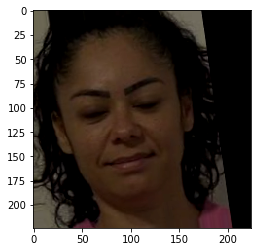

In [32]:
X, y = next(iter(train_dl))
plt.imshow(unnormalize(X[0]).permute(1, 2, 0))
print(y[0])

tensor(1)


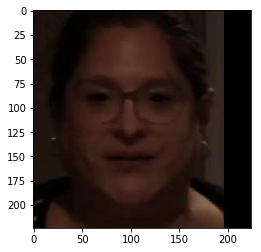

In [33]:
X, y = next(iter(val_dl))
plt.imshow(unnormalize(X[0]).permute(1, 2, 0))
print(y[0])

# Model

In [37]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [42]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        
#         # init
#         checkpoint = torch.load("../input/pretrained-pytorch/resnext50_32x4d-7cdf4587.pth")
#         self.load_state_dict(checkpoint)
#         del checkpoint
        
        self.fc = nn.Linear(2048, 1)
              

In [44]:
model = MyResNeXt()

# transfer learning
freeze_until(model, 'layer4.0.conv1.weight')
for n, p in model.named_parameters():
    if p.requires_grad:
        print(n)
        
# device       
model = model.to(device)

layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.conv3.weight
layer4.0.bn3.weight
layer4.0.bn3.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
layer4.1.conv3.weight
layer4.1.bn3.weight
layer4.1.bn3.bias
layer4.2.conv1.weight
layer4.2.bn1.weight
layer4.2.bn1.bias
layer4.2.conv2.weight
layer4.2.bn2.weight
layer4.2.bn2.bias
layer4.2.conv3.weight
layer4.2.bn3.weight
layer4.2.bn3.bias
fc.weight
fc.bias


In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WD)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience=config.PATIENCE, 
                                                       mode='min', 
                                                       factor=config.FACTOR, 
                                                       verbose=True, 
                                                       min_lr=1e-5)

In [46]:
checkpoint = torch.load("../input/dfdcresnetxt045962/best_model.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
del checkpoint

# Training & Evaluating

In [55]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)

    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size
            pbar.update()
            total_examples += batch_size
            

    bce_loss /= total_examples


    if silent:
        return bce_loss
    else:
        print("BCE: %.4f" % (bce_loss))
        
    if scheduler is not None:
        scheduler.step(bce_loss)

In [56]:
def fit(epochs, train_dl, val_dl, net, optimizer, cv):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(train_dl), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            
            bce_loss = 0
            total_examples = 0

            net.train(True)

            for batch_idx, data in enumerate(train_dl):
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)

                total_examples += batch_size
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss = evaluate(net, val_dl, device=device, silent=True)
            history["val_bce"].append(val_bce_loss)
            
            print("              val BCE: %.4f" % (val_bce_loss))

            # TODO: can do LR annealing here
            # TODO: can save checkpoint here
            # save the best model
            if round(val_bce_loss, 4) <= round(min(history['val_bce']), 4):
                print('save the model')
                ck = {'epoch': epochs_done, 
                     'state_dict': net.state_dict(),
                     'optimizer': optimizer.state_dict(),
                     'val_loss': round(val_bce_loss, 4)}
                path = 'best_model_'+str(cv)+'.pth'
                torch.save(ck, path)
                

            print("")

In [49]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [50]:
history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

In [52]:
evaluate(model, val_dl, device=device)

BCE: 0.1882


### 1) only CV
training times = epoch X cv = 5 X 5 = 25

In [57]:
set_lr(optimizer, 1e-3)

for i in range(config.CV):
    # reset to save model
    history = { "train_bce": [], "val_bce": [] }
    
    
    # reset the mode
    model = MyResNeXt()
    freeze_until(model, 'layer4.0.conv1.weight')    
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WD)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           patience=config.PATIENCE, 
                                                           mode='min', 
                                                           factor=config.FACTOR, 
                                                           verbose=True, 
                                                           min_lr=1e-5)
    
    checkpoint = torch.load("../input/dfdcresnetxt045962/best_model.pth")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    del checkpoint
    
    
    # prepare the data
    train_dataset = VideoDataset(train_dfs[i], "train", True)
    train_dl = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)

    val_dataset = VideoDataset(val_dfs[i], "val", True)
    val_dl = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
                        num_workers=0, pin_memory=True)
    
    
    fit(5, train_dl, val_dl, model, optimizer, i)
    

train dataset has 12859 real videos, 12859 fake videos
val dataset has 3215 real videos, 3215 fake videos


Epoch:   1, train BCE: 0.2859
              val BCE: 0.1967
save the model

Epoch:   2, train BCE: 0.2737
              val BCE: 0.2581

Epoch:   3, train BCE: 0.2622
              val BCE: 0.1918
save the model

Epoch:   4, train BCE: 0.2519
              val BCE: 0.2127

Epoch:   5, train BCE: 0.2382
              val BCE: 0.2287

train dataset has 12859 real videos, 12859 fake videos
val dataset has 3215 real videos, 3215 fake videos


Epoch:   6, train BCE: 0.2876
              val BCE: 0.2164
save the model

Epoch:   7, train BCE: 0.2701
              val BCE: 0.2036
save the model

Epoch:   8, train BCE: 0.2625
              val BCE: 0.2038

Epoch:   9, train BCE: 0.2480
              val BCE: 0.2147

Epoch:  10, train BCE: 0.2428
              val BCE: 0.2232

train dataset has 12859 real videos, 12859 fake videos
val dataset has 3215 real videos, 3215 fake videos


Epoch:  11, train BCE: 0.2889
              val BCE: 0.2490
save the model

Epoch:  12, train BCE: 0.2710
              val BCE: 0.2155
save the model

Epoch:  13, train BCE: 0.2617
              val BCE: 0.1924
save the model

Epoch:  14, train BCE: 0.2562
              val BCE: 0.1936

Epoch:  15, train BCE: 0.2463
              val BCE: 0.1923
save the model

train dataset has 12859 real videos, 12859 fake videos
val dataset has 3215 real videos, 3215 fake videos


Epoch:  16, train BCE: 0.2880
              val BCE: 0.2019
save the model

Epoch:  17, train BCE: 0.2697
              val BCE: 0.1977
save the model

Epoch:  18, train BCE: 0.2614
              val BCE: 0.1872
save the model

Epoch:  19, train BCE: 0.2476
              val BCE: 0.2321

Epoch:  20, train BCE: 0.2442
              val BCE: 0.2167

train dataset has 12860 real videos, 12860 fake videos
val dataset has 3214 real videos, 3214 fake videos


Epoch:  21, train BCE: 0.2904
              val BCE: 0.2201
save the model

Epoch:  22, train BCE: 0.2693
              val BCE: 0.2044
save the model

Epoch:  23, train BCE: 0.2618
              val BCE: 0.2256

Epoch:  24, train BCE: 0.2532
              val BCE: 0.2028
save the model

Epoch:  25, train BCE: 0.2431
              val BCE: 0.2032



In [58]:
!ls

__notebook_source__.ipynb  best_model_1.pth  best_model_3.pth
best_model_0.pth	   best_model_2.pth  best_model_4.pth


### 2) full undersampling + CV
training times = undersample part X epoch X cv = 5 X 5 X 5 = 125

In [ ]:
# optimizer = torch.optim.Adam(net_xception.parameters(), lr=lr, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, mode='min', factor=factor, verbose=True, min_lr=1e-5)

In [ ]:
# evaluate(net_xception, val_dl, device=gpu)

In [ ]:
# set_lr(optimizer, lr)
# fit(5, train_dl, val_dl, net_xception, optimizer)

Plot training progress. It's nicer to use something like TensorBoard for this, but a simple plot also works. ;-)

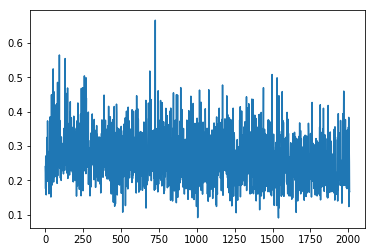

In [59]:
plt.plot(history["train_bce"])

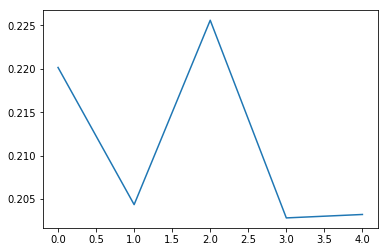

In [60]:
plt.plot(history["val_bce"])

**All done!** You can now use this checkpoint in the [inference kernel](https://www.kaggle.com/humananalog/inference-demo).

# Test

In [ ]:
# final model
evaluate(net, test_dl, device=device)

In [ ]:
# reset to best model
ck = torch.load('best_model_.pth')
net.load_state_dict(ck['state_dict'])
optimizer.load_state_dict(ck['optimizer'])

In [ ]:
# best model 
evaluate(net, test_dl, device=device)

In [61]:
from IPython.display import FileLink
FileLink('best_model_0.pth') 

/kaggle/working/best_model_0.pth

In [62]:
# dwonload the file
from IPython.display import FileLink
FileLink('best_model_1.pth') 

/kaggle/working/best_model_1.pth

In [63]:
from IPython.display import FileLink
FileLink('best_model_2.pth') 

/kaggle/working/best_model_2.pth

In [64]:
from IPython.display import FileLink
FileLink('best_model_3.pth') 

/kaggle/working/best_model_3.pth

In [65]:
from IPython.display import FileLink
FileLink('best_model_4.pth') 

/kaggle/working/best_model_4.pth